In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Bidirectional
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load IMDB dataset
vocab_size = 10000  # Use the top 10,000 most frequent words
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# View a sample
word_index = imdb.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}
decoded_review = " ".join([reverse_word_index.get(i - 3, "?") for i in X_train[0]])
print(f"Sample review: {decoded_review}")
print(f"Sentiment (0=negative, 1=positive): {y_train[0]}")

Training samples: 25000
Test samples: 25000
Sample review: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing 

In [2]:
max_length = 100  # Maximum review length
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [3]:
# Load GloVe embeddings
embedding_dim = 100
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [4]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix] if 'embedding_matrix' in locals() else None, trainable=True),
    LSTM(128),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(128),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [6]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.5270 - loss: 0.6966 - val_accuracy: 0.5818 - val_loss: 0.6769
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.6368 - loss: 0.6392 - val_accuracy: 0.7556 - val_loss: 0.5088
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.7681 - loss: 0.4996 - val_accuracy: 0.8014 - val_loss: 0.4558
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8267 - loss: 0.4044 - val_accuracy: 0.8122 - val_loss: 0.4286
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.9079 - loss: 0.2627 - val_accuracy: 0.8112 - val_loss: 0.4747


In [7]:
# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step
              precision    recall  f1-score   support

    Negative       0.75      0.85      0.80     12500
    Positive       0.83      0.72      0.77     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



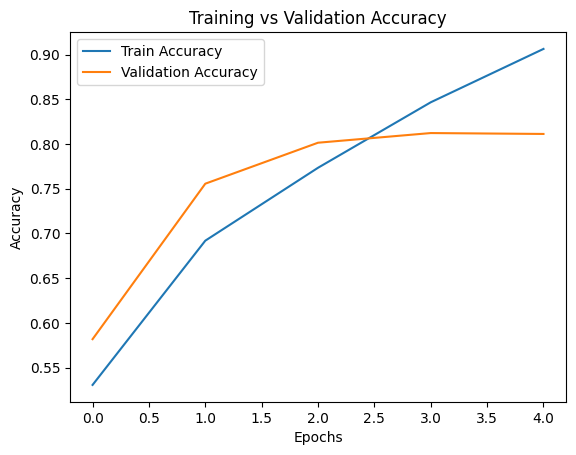

In [8]:
# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

In [9]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    LSTM(128, return_sequences=True),
    Dropout(0.2),  # Drop 20% of neurons
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


In [10]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    LSTM(128, kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])


In [11]:
from tensorflow.keras.layers import Embedding, GRU

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    GRU(64),
    Dense(1, activation='sigmoid')
])


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    GRU(64),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',  # Use Adam optimizer
    loss='binary_crossentropy',  # Loss function for binary classification
    metrics=['accuracy']  # Metric to evaluate performance
)

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)



Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.5578 - loss: 0.6697 - val_accuracy: 0.7630 - val_loss: 0.5279
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8077 - loss: 0.4687 - val_accuracy: 0.7932 - val_loss: 0.4499
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.8810 - loss: 0.3004 - val_accuracy: 0.8232 - val_loss: 0.4095
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9297 - loss: 0.1965 - val_accuracy: 0.8126 - val_loss: 0.4523
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9582 - loss: 0.1235 - val_accuracy: 0.8024 - val_loss: 0.5968
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9777 - loss: 0.0750 - val_accuracy: 0.8096 - val_loss: 0.6636


In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8087 - loss: 0.4328
Test Accuracy: 0.8108800053596497


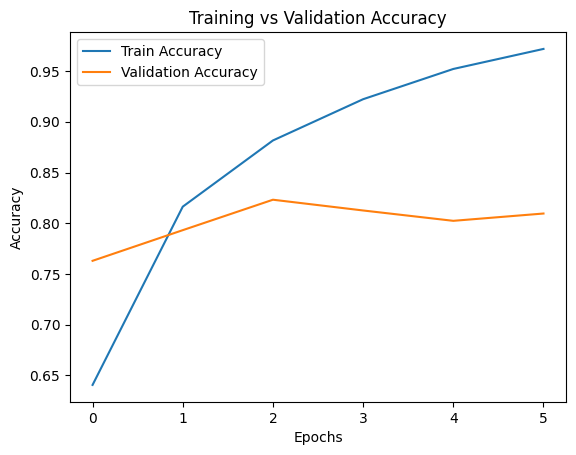

In [14]:
# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

predictions = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
[[10229  2271]
 [ 2457 10043]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.81     12500
           1       0.82      0.80      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



In [16]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)  # Lower or increase the learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(GRU(64)),  # Wrap GRU in a Bidirectional layer
    Dense(1, activation='sigmoid')
])


In [18]:
# Define the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    GRU(64),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',              # Optimizer
    loss='binary_crossentropy',    # Loss function for binary classification
    metrics=['accuracy']           # Evaluation metric
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,                      # Number of epochs
    batch_size=64,                  # Batch size
    validation_data=(X_val, y_val)  # Validation data
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5555 - loss: 0.6710 - val_accuracy: 0.7860 - val_loss: 0.4983
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8381 - loss: 0.3967 - val_accuracy: 0.8092 - val_loss: 0.4312
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9064 - loss: 0.2558 - val_accuracy: 0.8250 - val_loss: 0.4412
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9401 - loss: 0.1714 - val_accuracy: 0.8186 - val_loss: 0.4671
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9635 - loss: 0.1124 - val_accuracy: 0.8194 - val_loss: 0.5541
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9786 - loss: 0.0664 - val_accuracy: 0.8168 - val_loss: 0.6753
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9830 - loss: 0.0512 - val_accuracy: 0.8128 - val_loss: 0.7842
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9910 - loss: 0.0300 - 

In [19]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    GRU(64, return_sequences=True),
    Dropout(0.5),                # Dropout layer
    GRU(64),
    Dropout(0.5),                # Dropout layer
    Dense(1, activation='sigmoid')
])


In [20]:
from tensorflow.keras.regularizers import l2

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))


In [21]:
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    GRU(32),  # Reduce units from 64 to 32
    Dense(1, activation='sigmoid')
])


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Model definition
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    GRU(64),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.5810 - loss: 0.6583 - val_accuracy: 0.7876 - val_loss: 0.4967
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8466 - loss: 0.3755 - val_accuracy: 0.8246 - val_loss: 0.4161
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9040 - loss: 0.2528 - val_accuracy: 0.8202 - val_loss: 0.4261
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9400 - loss: 0.1687 - val_accuracy: 0.8144 - val_loss: 0.4956
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9647 - loss: 0.1100 - val_accuracy: 0.8194 - val_loss: 0.5651


In [23]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8104 - loss: 0.4378
Test Accuracy: 0.8092399835586548


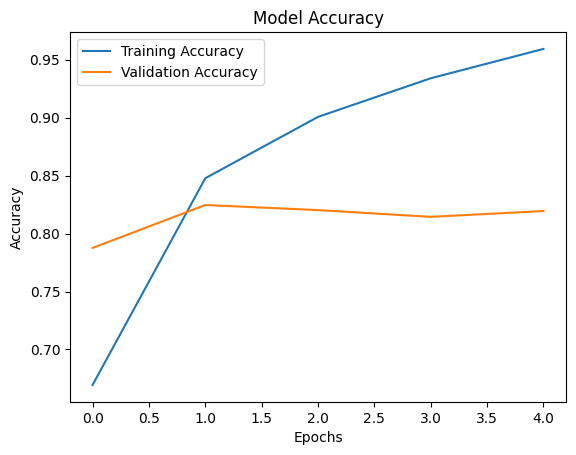

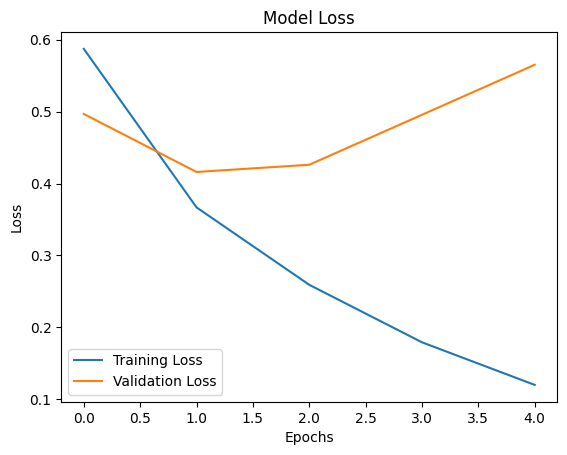

In [24]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save("sentiment_model_dropout.h5")
print("Model saved successfully!")
